# THƯ VIỆN CẦN THIẾT

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

# PHÂN TÍCH DỮ LIỆU
- [INSERT MÔ TẢ SƠ BỘ VỀ 3 FILE/CÁC CÂU HỎI/CÁC BƯỚC LÀM]

## I. TIỀN XỬ LÝ DỮ LIỆU
### Dữ liệu có bao nhiêu dòng, bao nhiêu cột?

In [356]:
df_playlist = pd.read_csv("data/playlist.csv")
df_track    = pd.read_csv("data/track.csv")
df_user     = pd.read_csv("data/user.csv")

df_playlist.shape, df_track.shape, df_user.shape

((3383, 6), (46544, 11), (22161, 7))

### Các file dữ liệu có các dòng nào bị trùng lắp hoàn toàn không?
- Thấy rằng từ output, không có dòng nào bị trùng lắp hoàn toàn trong từng file dữ liệu

In [357]:
df_playlist.duplicated().sum(), df_track.duplicated().sum(), df_user.duplicated().sum()

(0, 0, 0)

### Mỗi cột thuộc kiểu dữ liệu nào? Có cột nào bị thiếu dữ liệu không?
- Với mỗi file, kết hợp 2 công việc này vào 1 dataframe. Dataframe này gồm các cột chính là các cột thuộc tính trong lần lượt 3 file x 2 hàng có tên: 
    - `DataType` - thể hiện kiểu dữ liệu của các thuộc tính trong file
    - `NaN counts` - đếm số lượng dữ liệu thiếu tại mỗi cột  
- Theo đồ án 1, ý nghĩa của mỗi thuộc tính trong mỗi file như sau:
    - `playlist.csv`:
        - `id`: mã của playlist đó, mã này dùng để phân biệt với các playlist khác, mỗi playlist sẽ có một mã số `id` duy nhất.
        - `name`: là tên của playlist đó (trong trường hợp playlist đó không có tên thì ta gán `name` là `null`).
        - `genre`: là thể loại của playlist đó (trong trường hợp playlist đó chưa được đặt thể loại thì ta gán `genre` là `null`).
        - `likes_count`: tổng số lượt likes của playlist
        - `track_ids`: là chuỗi gồm danh sách các track có track_id nằm trong playlist đó.
    - `track.csv`:
        - `id`: id của track. Lưu ý 1 track có thể nằm trong nhiều playlist
        - `name`: tên track
        - `genre`: thể loại track
        - `playlist_id`: playlist_id mà track có mã là `id` thuộc về
        - `author_id`: mỗi track có 1 user có mã đại diện là `author_id` phụ trách
        - `likes_count`: tổng số lượt likes của track
        - `playback_count`: tổng số lượt replay của track
        - `download_count`: tổng số lượt tải về track đó
        - `created_date`: ngày track đó được tạo
    - `user.csv`:
        - `id`: mã người dùng, là duy nhất. Lưu ý 1 người dùng có thể phụ trách 1 hoặc nhiều track
        - `full_name`: họ và tên user
        - `username`: tên tài khoản user
        - `track_id`: track mà user 
        - `followers_count`: số lượng người theo dõi user đó

In [358]:
pd.DataFrame([df_playlist.dtypes, (df_playlist.isna().sum()/df_playlist.shape[0]*100).round(2)], index= ['type', 'missing percentage'])

,playlist_id,playlist_name,genre,likes_count,reposts_count,track_ids
type,int64,object,object,int64,int64,object
missing percentage,0.0,0.0,80.14,0.0,0.0,1.09


In [359]:
pd.DataFrame([df_track.dtypes, (df_track.isna().sum()/df_track.shape[0]*100).round(2)], index= ['type', 'missing percentage'])

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,reposts_count,comment_count,created_date
type,int64,object,object,int64,int64,float64,float64,float64,int64,float64,object
missing percentage,0.0,0.0,14.41,0.0,0.0,1.84,1.84,1.84,0.0,2.11,0.0


In [360]:
pd.DataFrame([df_user.dtypes, (df_user.isna().sum()/df_user.shape[0]*100).round(2)], index= ['type', 'missing percentage'])

,user_id,full_name,username,followers_count,track_count,country_code,verified
type,int64,object,object,int64,int64,object,bool
missing percentage,0.0,38.55,0.0,0.0,0.0,41.69,0.0


### Xử lý dòng bị thiếu dữ liệu 

### a) Loại dòng thiếu dữ liệu

-  File `playlist.csv`: từ mô tả thuộc tính và kiểu dữ liệu của `track_ids`, thì cần loại đi các playlist không có track nào (tức thuộc tính `track_ids` bị thiếu). Ngoài ra, cũng có 2706 dòng bị thiếu thuộc tính `genre` nhưng qua quan sát sơ bộ file `playlist.csv`, hầu hết tên các playlist (`playlist_name`) sẽ được đặt theo tên thể loại nhạc nên ta sẽ không xóa các dòng thiếu thuộc tính `genre`

In [361]:
df_playlist = df_playlist.dropna(subset=['track_ids'])
df_playlist.shape

(3346, 6)

- File `track.csv`: tương tự với cách giải thích của `playlist.csv`, ta sẽ không xóa các dòng thiếu thuộc tính `track_genre`. Tuy nhiên sẽ xóa các dòng thiếu thuộc tính likes_count, playback_count, download_count vì đây là các thuộc tính numeric quan trọng cho bước khám phá dữ liệu sau này

In [362]:
df_track = df_track.dropna(subset= ['track_genre', 'likes_count', 'playback_count', 'download_count', 'comment_count'])
df_track.shape

(39060, 11)

- File `user.csv`: không xóa dòng nào vì tuy các user có thể không có tên `full_name` nhưng ta vẫn có thể thao tác với dataframe df_user dựa vào định danh của user đó (tức `user_id`) 

### b) Thay thế giá trị trùng thành 1 giá trị khác

- Trong file `playlist.csv`, do cột genre bị thiếu khá nhiều (2706/3372) nên ta không loại các dòng thiếu genre được vì sẽ không đủ dữ liệu. Ngoài ra, có 2 vấn đề phát sinh 
    - _Vấn đề 1_: cột `genre` bị thiếu khá nhiều (2706/3372) nên ta không loại các dòng thiếu `genre` được vì sẽ không đủ dữ liệu để phân tích sau này 
    <br>=> Giải pháp: nội suy từ cột `playlist_name`. Từ quan sát file, thấy rằng hầu hết tên playlist có xu hướng thể hiện luôn thể loại của playlist đó. VD: `playlist_name` = *"Hip Hop Supreme"* thì có thể nội suy được thể loại là **hiphop**
    - _Vấn đề 2_: từ vấn đề 1, thấy rằng ở các playlist thiếu thuộc tính `genre` có thể mang nhiều thể loại. VD: `playlist_name` = *"| Chill | Lofi | Hip Hop |"* thì playlist đó có tới 3 thể loại: **[chill, lofi, hiphop]**. Ngoài ra, kể cả khi playlist có thuộc tính `genre` (VD: `genre` = *"LoFi hip hop"*) thì thấy rằng playlist vẫn có thể mang thuộc về nhiều thể loại
    <br>=> Giải pháp: ta cần phân rã (pd.explode()) cột `genre` phòng trường hợp 1 playlist thuộc nhiều thể loại
    - _Vấn đề 3_: giả sử giải quyết được 2 vấn đề trên thì thấy rằng tên thể loại vẫn chưa đồng nhất (VD: `genre` = *"Blue's_Music"* và `genre` = *"blues"*)
    <br>=> Giải pháp: cần 1 file `keywords.txt` để lưu cứng tên của các thể loại nhạc sẽ xuất hiện trong chuỗi string `genre` (file này được lấy từ project 1 và được tinh chỉnh lại để phù hợp). Ta sẽ chuẩn hóa thể loại dựa vào file này: xét chuỗi thể loại (VD: `genre` = *"Hip-hop & Rap"*), nếu chuỗi thể loại này chứa bất kỳ chuỗi con trong `keywords.txt` (VD: *"hiphop"* và *"rap"*) thì thể loại sẽ được thay bằng (tập) chuỗi con ấy (VD: `genre` sau khi chuẩn hóa = *["hiphop", "rap"]*)
- Kết hợp cả 3 giải pháp trên, ta được cách xử lý sau: 
    - Cộng 2 cột 'playlist_name' & 'genre', nếu 'genre' là NaN thì coi như chuỗi rỗng, kết quả cộng chuỗi lưu vào `df_playlist['genre']`
    - Chuẩn hóa `name_genre` theo giải pháp 3, kết quả sau khi chuẩn hóa là 1 list, lưu lại vào `name_genre`. Sau khi chuẩn hóa có thể vẫn tồn tại NaN nhưng ít hơn (NaN tồn tại là vì cột `playlist_name` không chứa thể loại nhạc nào nên không nội suy được + cột `genre` bị rỗng). Tiến hành bỏ đi các dòng chứa NaN này


In [363]:
with open('data/keywords.txt', encoding= 'utf-8') as f:
    keywords = f.readlines()
keywords = [item.strip('\n').strip(' ') for item in keywords]

In [364]:
# namegenre = playlist_name + playlist_genre
name_genre = df_playlist.apply(lambda row: row['playlist_name'] if pd.isna(row['genre']) else row['playlist_name'] + row['genre'], axis = 1)
name_genre

0          Best Rap Right Now: Drippin'Hip-hop & Rap
1                                    Hip Hop Supreme
2                   Lowfi hip hop chillsLofi Hip Hop
3       Hip-Hop Party Starters: Turn UpHip-hop & Rap
4                    Study & Chill | Lofi HiphopLofi
                            ...                     
3378                                 SOUTH EAST ASIA
3379                 South East Asia Travel Findings
3380                                 South East Asia
3381                           South East Asia music
3382                                 South East Asia
Length: 3346, dtype: object

In [365]:
def list_genres(genre_str, keywords=keywords):
    res = []

    for keyword in keywords:
        if keyword in genre_str:
            res.append(keyword)

    return res

df_playlist['genre'] = name_genre.apply(lambda val: list_genres(re.sub(r'(hip-hop|hip hop)', 'hiphop', val.lower())))
print("Số lượng NaN từng cột:")
print(df_playlist.explode('genre').isna().sum())
print("Sau khi bỏ 513 giá trị NaN cột genre:")
df_playlist = df_playlist.explode('genre').dropna()

df_playlist

Số lượng NaN từng cột:
playlist_id        0
playlist_name      0
genre            513
likes_count        0
reposts_count      0
track_ids          0
dtype: int64
Sau khi bỏ 513 giá trị NaN cột genre:


,playlist_id,playlist_name,genre,likes_count,reposts_count,track_ids
0,730118454,Best Rap Right Now: Drippin',hiphop,389303,21591,"1157194048,1134572425,1126802848,1163320396,11..."
0,730118454,Best Rap Right Now: Drippin',rap,389303,21591,"1157194048,1134572425,1126802848,1163320396,11..."
1,380154338,Hip Hop Supreme,hiphop,178876,9795,"594112890,596212962,593601912,597082389,597563..."
2,306226961,Lowfi hip hop chills,hiphop,203954,20707,"216774635,406234053,755194606,266707458,670884..."
2,306226961,Lowfi hip hop chills,chill,203954,20707,"216774635,406234053,755194606,266707458,670884..."
...,...,...,...,...,...,...
3378,503370612,SOUTH EAST ASIA,asia,1,0,"298786858,813312181"
3379,17969127,South East Asia Travel Findings,asia,0,0,10764237
3380,345496216,South East Asia,asia,0,0,315565008
3381,774255861,South East Asia music,asia,0,0,485316636


- Trong file `track.csv`, ta cũng đổi thể loại nhạc về thể loại nhạc được định nghĩa trong file keywords.txt 

In [366]:
# redefine function
def list_genres(genre_str, keywords=keywords):
    res = []

    for keyword in keywords:
        if keyword in genre_str:
            res.append(keyword)
    # if not res:
    #     res = genre_str.split('&')
    return res

df_track['track_genre'] = df_track['track_genre'].apply(lambda val: list_genres(re.sub(r'[\-\.\/ ]', '', val.lower())))
df_track = df_track.explode('track_genre')
df_track = df_track.drop(df_track[df_track['track_genre'] == ''].index)
df_track.head()

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,reposts_count,comment_count,created_date
0,1157194048,Polo G - Bad Man (Smooth Criminal),hiphop,730118454,454955073,104933.0,3656798.0,0.0,1484,2949.0,2021-11-10T00:16:07Z
1,1134572425,"Who Want Smoke?? (feat. G Herbo, Lil Durk & 21...",hiphop,730118454,811818505,229321.0,11713134.0,0.0,2994,7358.0,2021-10-01T21:15:32Z
2,1126802848,Rocc Climbing (feat. Lil Yachty),hiphop,730118454,277094000,191418.0,8635832.0,0.0,9338,3428.0,2021-09-18T08:16:48Z
2,1126802848,Rocc Climbing (feat. Lil Yachty),rap,730118454,277094000,191418.0,8635832.0,0.0,9338,3428.0,2021-09-18T08:16:48Z
3,1163320396,By Your Side,rap,730118454,29550459,84417.0,2861345.0,0.0,952,1064.0,2021-11-19T21:15:58Z


In [367]:
a = df_track['track_genre'].dropna()
a

0            hiphop
1            hiphop
2            hiphop
2               rap
3               rap
            ...    
46529        reggae
46530         house
46534        hiphop
46534           rap
46538    soundtrack
Name: track_genre, Length: 31812, dtype: object

### Chuyển đổi kiểu dữ liệu cho phù hợp


- File `playlist.csv`: từ mô tả thuộc tính và kiểu dữ liệu của `track_ids`, thì cần đổi kiểu dữ liệu của thuộc tính `track_ids` từ **string** sang dạng **list các số nguyên**

In [368]:
df_playlist['track_ids'] = df_playlist['track_ids'].apply(lambda x: [int(item) for item in x.split(',')])

- File `track.csv`: 
    - Cần đổi kiểu dữ liệu của 2 cột `likes_count`, `playback_count`từ **float** sang **int**
    - Cần đổi kiểu dữ liệu của `created_date` sang kiểu **datetime**

In [369]:
df_track[['likes_count', 'playback_count', 'download_count', 'comment_count']] = df_track[['likes_count', 'playback_count', 'download_count', 'comment_count']].astype(int)
df_track['created_date'] = pd.to_datetime(df_track['created_date'])
# df_track[['likes_count', 'playback_count', 'download_count', 'created_date']].head()

### Kiểm tra ngoại lệ

(array([1152.,  865.,  638.,  308.,  121.,   51.,   35.,   35.,   64.,
          38.]),
 array([ 0.        ,  1.29565591,  2.59131181,  3.88696772,  5.18262362,
         6.47827953,  7.77393543,  9.06959134, 10.36524725, 11.66090315,
        12.95655906]),
 <BarContainer object of 10 artists>)

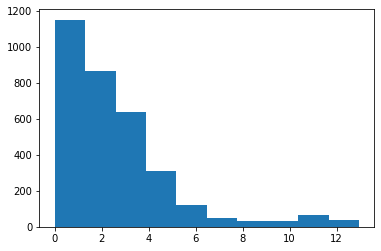

In [370]:
# tính mean
likes = df_playlist['likes_count']
likes = likes.loc[likes > 0]
likes = np.log(likes) #np.log(likes)

# plt.hist(likes, bins=20);
# g = sns.boxplot(x=likes)
plt.hist(likes)

In [371]:
# likes = pd.DataFrame(likes)
a,b = likes.quantile([0.25, 0.75])
likes = likes.loc[(a <= likes) & (likes <= b)]
likes
# sns.boxplot(x=likes)

9       3.401197
12      2.079442
18      2.484907
18      2.484907
21      1.098612
          ...   
3345    0.693147
3349    1.098612
3349    1.098612
3370    1.386294
3370    1.386294
Name: likes_count, Length: 1942, dtype: float64

(array([768., 350., 217., 139., 130.,  93.,  73.,  53.,  43.,  76.]),
 array([ 2.,  5.,  8., 11., 14., 17., 20., 23., 26., 29., 32.]),
 <BarContainer object of 10 artists>)

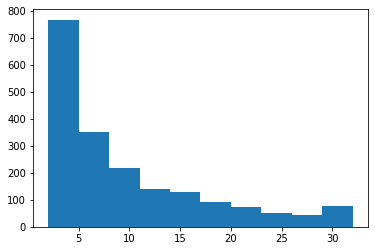

In [372]:
likes = df_playlist['likes_count'].loc[df_playlist['likes_count'] > 0]
a,b = likes.quantile([0.25, 0.75])
likes = likes.loc[(a <= likes) & (likes <= b)]
likes 

plt.hist(likes)

23087

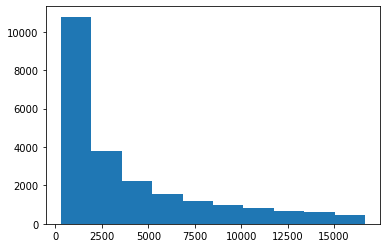

In [373]:
# track.csv
likes = df_track['likes_count'].loc[df_track['likes_count'] > 0]
a,b = likes.quantile([0.25, 0.75])
likes = likes.loc[(a <= likes) & (likes <= b)]
likes 

plt.hist(likes)
len(likes)

# II. KHÁM PHÁ DỮ LIỆU

????

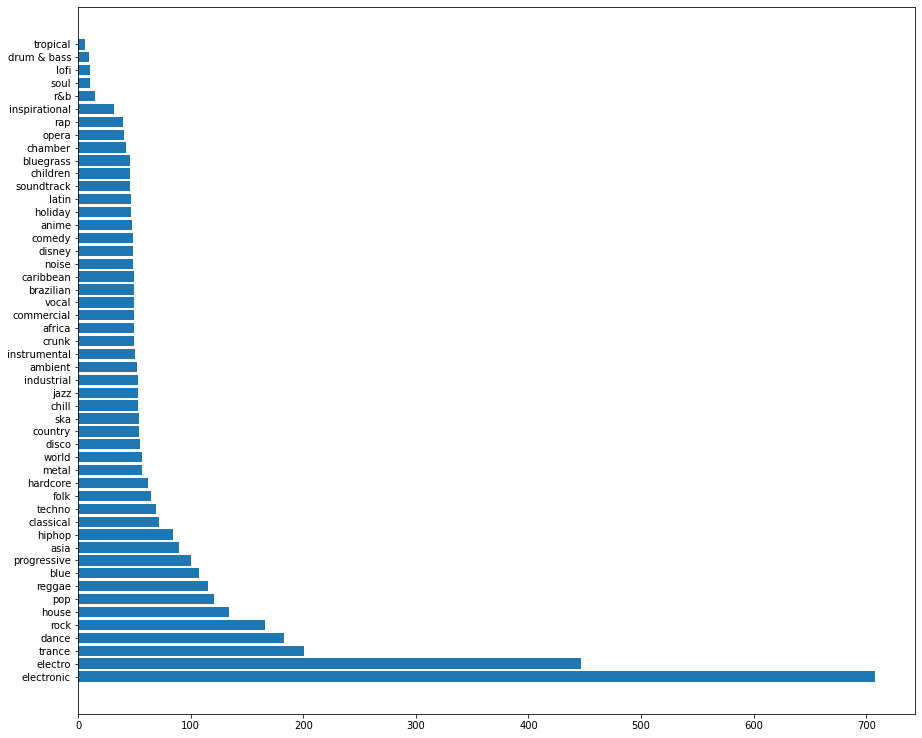

In [374]:
genre_stat = df_playlist['genre'].value_counts()
plt.figure(figsize=(15, 13))
a = plt.barh(genre_stat.index, genre_stat)

## Tương quan giữa likes_count với reposts_count của 1 playlist/track

- **Câu hỏi quan tâm**: Xét 1 playlist, có mối tương quan nào giữa số lượt thích (`likes_count`) và số lượt chia sẻ (`reposts_count`) ?
- Từ quan sát đồ thị correlation phía dưới, thấy rằng mối quan hệ giữa `số lượt thích` (biến ngẫu nhiên A) và `số lượt tái chia sẻ` (biến ngẫu nhiên B) tỷ lệ thuận, tuy nhiên mối quan hệ chỉ thực sự mạnh khi A và B dưới 150000, còn A,B bắt đầu trên 150000 thì các điểm dữ liệu thưa thớt dần chứng tỏ mối quan hệ càng yếu dần  

Text(0, 0.5, 'Số lượt tái chia sẻ (reposts_count)')

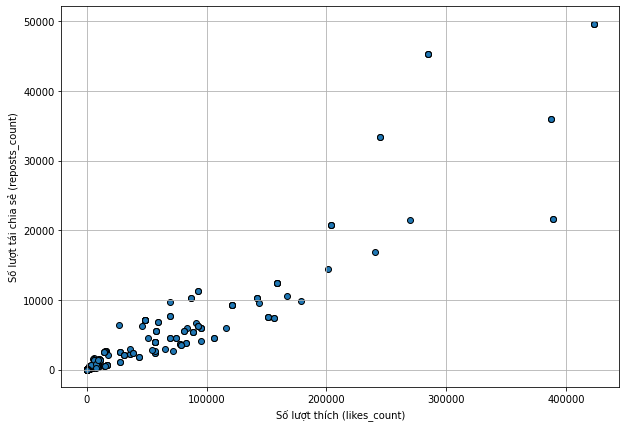

In [376]:
plt.figure(figsize=(10,7))
plt.grid()
plt.scatter(df_playlist['likes_count'], df_playlist['reposts_count'], edgecolors='black')
plt.xlabel('Số lượt thích (likes_count)'); plt.ylabel('Số lượt tái chia sẻ (reposts_count)')
# plt.axvline(np.mean(df_playlist['likes_count']), color='r', linestyle='--') # lượt like TB

Để thể hiện sự tương quan giữa A và B bằng 1 con số, ta dùng ma trận tương quan `Pearson correlation matrix`, thấy rằng độ tương quan là ~0.9394

In [377]:
likes_reposts = df_playlist[['likes_count', 'reposts_count']]
likes_reposts.corr(method = 'pearson')

,likes_count,reposts_count
likes_count,1.000000,0.939395
reposts_count,0.939395,1.000000


Tuy nhiên, con số ~0.9394 chưa thực sự chính xác vì tương quan Pearson giả định 2 thuộc tính có phân phối chuẩn, trong khi thuộc tính `likes_count` không đảm bảo điều đó. Vì vậy, ta chuyển qua dùng tương quan Spearman, thấy rằng mối tương quan giảm còn ~0.8

- Phân phối của thuộc tính `likes_count`

Text(0.5, 1.0, 'Phân phối của likes_count')

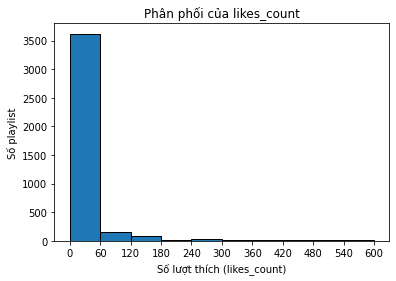

In [378]:
a = plt.hist(df_playlist['likes_count'], range= (0,600), edgecolor='black')
plt.xticks(a[1])
plt.xlabel('Số lượt thích (likes_count)')
plt.ylabel('Số playlist')
plt.title('Phân phối của likes_count')

- Tính độ tương quan bằng phương pháp Spearman

In [379]:
likes_reposts.corr(method = 'spearman')

,likes_count,reposts_count
likes_count,1.000000,0.799104
reposts_count,0.799104,1.000000


## Tương quan giữa likes_count và reposts_count của 1 track
- Câu hỏi quan tâm: 

Text(0, 0.5, 'Số lượt tái chia sẻ (reposts_count)')

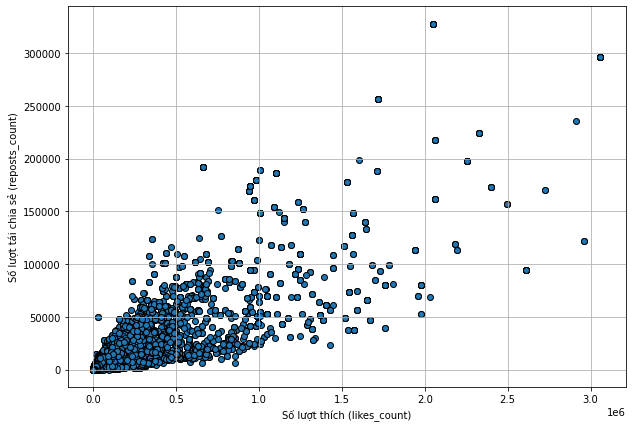

In [380]:
plt.figure(figsize=(10,7))
plt.grid()
plt.scatter(df_track['likes_count'], df_track['reposts_count'], edgecolors='black')
plt.xlabel('Số lượt thích (likes_count)')
plt.ylabel('Số lượt tái chia sẻ (reposts_count)')

In [381]:
likes_reposts = df_track[['likes_count', 'reposts_count']]
likes_reposts.corr(method = 'spearman')

,likes_count,reposts_count
likes_count,1.000000,0.964503
reposts_count,0.964503,1.000000


## Tương quan giữa followers_count & track_count của 1 verified user
- **Câu hỏi quan tâm**: Liệu ra nhiều track có đồng nghĩa nhiều người theo dõi hơn để từ đó có thể các user đăng tải nhiều track hơn?
- Từ quan sát đồ thị, dễ thấy rằng không có sự tương quan nào giữa số người theo dõi và số track

Text(0, 0.5, 'Số lượng track (track_count)')

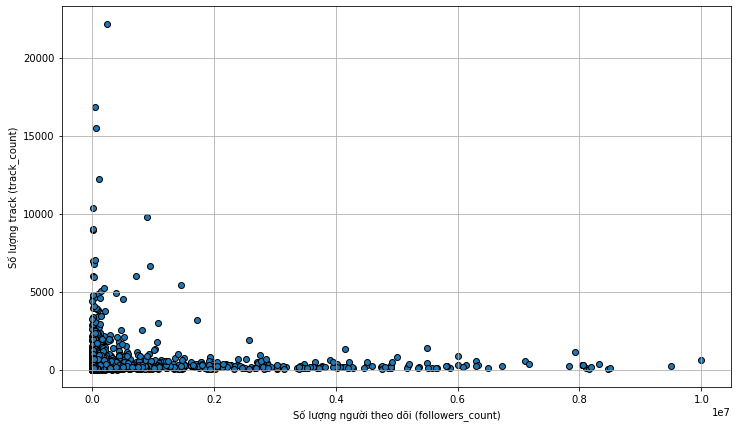

In [382]:
verified_users = df_user[df_user['verified'] == True]
verified_users

plt.figure(figsize=(12,7))
plt.grid()
plt.scatter(verified_users['followers_count'], verified_users['track_count'], edgecolors='black')
plt.xlabel('Số lượng người theo dõi (followers_count)')
plt.ylabel('Số lượng track (track_count)')

## Mối tương quan giữa likes_count, playback_count, download_count, reposts_count, comment_count

In [383]:
df = df_track[['likes_count','playback_count','download_count','reposts_count','comment_count']]
df

,likes_count,playback_count,download_count,reposts_count,comment_count
0,104933,3656798,0,1484,2949
1,229321,11713134,0,2994,7358
2,191418,8635832,0,9338,3428
2,191418,8635832,0,9338,3428
3,84417,2861345,0,952,1064
...,...,...,...,...,...
46537,390,20247,0,22,7
46538,22,1836,0,3,0
46539,2544,284610,0,75,8
46541,23,321,14,2,0


[Text(0.5, 0, 'likes_count'),
 Text(1.5, 0, 'playback_count'),
 Text(2.5, 0, 'download_count'),
 Text(3.5, 0, 'reposts_count'),
 Text(4.5, 0, 'comment_count')]

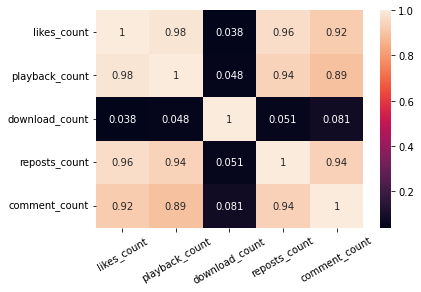

In [384]:
corr = df.corr(method='spearman')
g = sns.heatmap(corr, annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

- Các biến này có độc lập với nhau không?

## Tần suất ra track (số track/năm) có phụ thuộc (tỉ lệ thuận/nghịch) vào likes_count, playback_count, comment_count
- phụ thuộc: (in)dependent variable?

In [385]:
# tính cột tần suất
df = df_track[['author_id', 'track_id', 'created_date']]
df['track_id'] = df['track_id'].astype(object)
a = df_user.set_index('user_id').join(df.set_index('author_id'), on='user_id', how='inner')
a = a.loc[a['created_date'].dt.year == 2014]

C:\Users\Admin\AppData\Local\Temp/ipykernel_275020/2270554566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['track_id'] = df['track_id'].astype(object)


In [386]:
tmp = a.groupby(a.index)[['track_id', 'created_date']]
tmp.agg(track_count = ('track_id','count'),
        date = ('created_date', lambda x: x)).sort_values(by='track_count', ascending=False)
# tmp.first()

,track_count,date
user_id,,
175766,208,"[2014-10-27 10:22:24+00:00, 2014-10-15 07:19:1..."
351064,61,"[2014-12-11 20:21:55+00:00, 2014-07-07 19:41:0..."
630356,56,"[2014-10-24 11:32:55+00:00, 2014-01-20 15:35:3..."
1701116,56,"[2014-02-12 02:24:19+00:00, 2014-02-12 02:24:1..."
13909117,38,"[2014-03-28 15:14:46+00:00, 2014-02-13 13:48:5..."
...,...,...
12764379,1,2014-06-14 21:27:36+00:00
12773649,1,2014-12-27 12:56:51+00:00
12809050,1,2014-01-19 18:11:05+00:00
